In [1]:
import yfinance as yf
import statsmodels.api as sm
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.stattools import adfuller
from datetime import datetime, timedelta
import numpy as np
from itertools import combinations
import MetaTrader5 as mt5
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

In [13]:
def get_pairs(location):
    mt5.initialize()

    symbol_list = []
    for symbol in mt5.symbols_get():
        if location in symbol.path:
            symbol_list.append(symbol)
            
    return list(combinations(symbol_list, 2))

In [19]:
def get_bars(symbol, start_date, end_date, timeframe=mt5.TIMEFRAME_M1):
    mt5.initialize()
    bars = mt5.copy_rates_range(symbol, timeframe, start_date, end_date)
    df_bars = pd.DataFrame(bars)
    df_bars["time"] = pd.to_datetime(df_bars["time"], unit="s")
    return df_bars

In [20]:
def get_pairs_close(symbol_pair, start_date, end_date):
    mt5.initialize()
    
    close0 = get_bars(symbol_pair[0].name, start_date, end_date)['close']
    close1 = get_bars(symbol_pair[1].name, start_date, end_date)['close']
    
    if close0.empty or close1.empty:
        return pd.Series([], dtype='float64')
    else:
        pairs_close_data = pd.concat([close0, close1], axis=1, keys = ['close0', 'close1']).dropna()
        return pairs_close_data

In [2]:
def first_cointegration_test(pair_close_data):
    COINTEGRATION_CONFIDENCE_LEVEL = 95
    result = coint_johansen(pair_close_data, 0, 1)
    
    confidence_level_cols = {
        90: 0,
        95: 1,
        99: 2
    }
    confidence_level_col = confidence_level_cols[COINTEGRATION_CONFIDENCE_LEVEL]
    
    trace_crit_value = result.cvt[:, confidence_level_col]
    eigen_crit_value = result.cvm[:, confidence_level_col]
    
    if np.all(result.lr1 >= trace_crit_value) and np.all(result.lr2 >= eigen_crit_value):
        return True
    else:
        return False

In [3]:
# Engle-Granger test
def second_cointegration_test(pair_close_data):
    # Step 1: Perform OLS regression of one time series on the other
    y = pair_close_data.iloc[:, 0]
    x = sm.add_constant(pair_close_data.iloc[:, 1])
    model = sm.OLS(y, x)
    results = model.fit()
    
    # Step 2: Test residuals for stationarity using ADF test
    residuals = y - results.predict(x)
    adf_result = adfuller(residuals)
    
    # Step 3: If residuals are stationary, the two time series are considered cointegrated
    if adf_result[1] < 0.05:
        return results.params[1]
    else:
        return None


In [25]:
def first_sieve(all_pairs, start_date, end_date):
    candidate_stationary_pairs = []
    for pair in tqdm(all_pairs):
        pairs_close_data = get_pairs_close(pair, start_date, end_date)
        if pairs_close_data.empty:
            continue
        else:
            if first_cointegration_test(pairs_close_data):
                candidate_stationary_pairs.append(pair)
                
    return candidate_stationary_pairs

In [26]:
def second_sieve(candidate_stationary_pairs, start_date, end_date):
    stationary_pairs = []
    for pair in tqdm(candidate_stationary_pairs):
        pairs_close_data = get_pairs_close(pair, start_date, end_date)
        if pairs_close_data.empty:
            continue
        else:
            slope = second_cointegration_test(pairs_close_data) 
            if slope:
                stationary_pairs.append({'coint_pair': pair, 'slope' : slope})
                
    return stationary_pairs

In [114]:
#1 Get all symbols and form a list of pairs
location = "Retail\\Forex"
all_pairs = get_pairs(location)  

end_date = datetime.now()
start_date = end_date - timedelta(days = 1)

#2 For all pairs check for stationarity and return a list of pairs that are stationary
candidate_stationary_pairs = first_sieve(all_pairs, start_date, end_date)
stationary_pairs = second_sieve(candidate_stationary_pairs, start_date, end_date)

100%|██████████████████████████████████████████████████████████████████████████████████| 70/70 [00:03<00:00, 21.37it/s]


In [115]:
#print((len(candidate_stationary_pairs) * 100) / len(all_pairs))
#print(len(all_pairs))
#print(len(candidate_stationary_pairs))
#print(len(stationary_pairs))

for data in stationary_pairs:
    print(data['coint_pair'][0].name, data['coint_pair'][1].name, data['slope'])


GBPUSD USDCAD -0.7108245763529889
GBPUSD EURTRY 0.03420191990190327
GBPUSD GBPTRY 0.028617686374499903
EURAUD GBPAUD 0.7513399441211197
CHFJPY EURGBP 363.24450616032226
EURGBP GBPCAD -0.14381938285014728
EURGBP EURSGD 0.18678345031064847
EURCAD GBPCAD 0.5930436848962484
EURCAD AUDSGD 0.020989694452891783
EURCAD EURTRY 0.004044631437212974
EURCAD GBPAUD -0.0043736486741160485
EURCAD USDTRY -0.028012109901219245
GBPCAD AUDSGD -0.06702730756415809
GBPCAD EURSGD -0.042524076399070854
GBPCAD GBPAUD 0.09980616015122878
GBPCAD GBPSGD 0.1618809999283295
GBPCAD NZDCHF -0.2809280135408537
GBPCAD USDTRY -0.02391871956419525
GBPCAD ZARJPY -0.017402391792786246
EURTRY GBPTRY 0.8261037039293354
EURZAR GBPSGD 13.193426496351371
EURZAR USDTRY -2.023509224471663
GBPSGD GBPTRY 0.018812361666990414
GBPSGD NOKSEK 0.4494668992995017
GBPTRY NZDCHF 16.835394584825465
NOKSEK USDMXN -0.00663017979733195
USDTRY USDZAR -0.04920370045984557


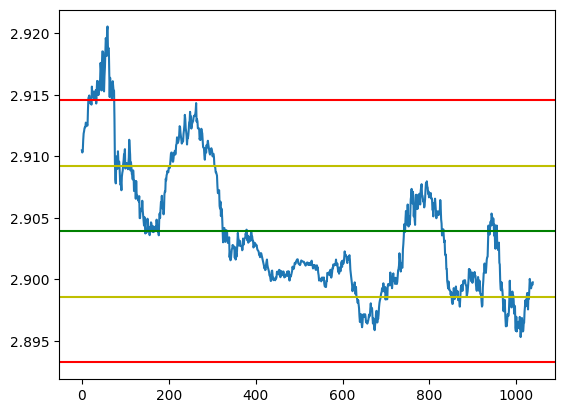

In [189]:
index = 3
stationary_pair = get_pairs_close(stationary_pairs[index]['coint_pair'], start_date, end_date)
beta = stationary_pairs[0]['slope']
equation = stationary_pair['close0'] - beta * stationary_pair['close1']
plt.plot(equation)
plt.axhline(equation.mean(), color='g', linestyle='-')
plt.axhline(equation.mean() + equation.std(), color='y', linestyle='-')
plt.axhline(equation.mean() - equation.std(), color='y', linestyle='-')
plt.axhline(equation.mean() + 2 * equation.std(), color='r', linestyle='-')
plt.axhline(equation.mean() - 2 * equation.std(), color='r', linestyle='-')
plt.show()

In [192]:
def in_sample_backtester(equation, account_balance=1000, percentage_of_portfolio_at_risk=0.05, risk_tolerance = 0.01):
    print(f'ACCOUNT BALANCE: {account_balance}')
    print(f'PERCENTAGE AT RISK: {percentage_of_portfolio_at_risk}')
    print(f'RISK TOLERANCE: {risk_tolerance}')
    print()
    
    win_counter = 0
    loss_counter = 0
    
    total_losses_allowed = account_balance * percentage_of_portfolio_at_risk
    position_size = account_balance * risk_tolerance

    entry_high = equation.mean() + equation.std()
    entry_low = equation.mean() - equation.std()
    stop_loss_high = equation.mean() + 2 * equation.std()
    stop_loss_low = equation.mean() - 2 * equation.std()
    take_profit = equation.mean()

    in_a_position = False
    for i in range(1, len(equation)):
        if not in_a_position:
            if equation[i-1] < entry_high and equation[i] >= entry_high:
                print('Buy High', equation[i])
                in_a_position = True
                continue
            elif equation[i-1] > entry_low and equation[i] <= entry_low:
                print('Buy Low', equation[i])
                in_a_position = True
                continue
            else:
                continue
            
        if in_a_position:
            if equation[i-1] > take_profit and equation[i] <= take_profit:
                print('TP High', equation[i])
                in_a_position = False
                win_counter += 1
                account_balance += position_size
                print(account_balance)
                continue
            elif equation[i-1] < take_profit and equation[i] >= take_profit:
                print('TP Low', equation[i])
                in_a_position = False
                win_counter += 1
                account_balance += position_size
                print(account_balance)
                continue
            elif equation[i-1] < stop_loss_high and equation[i] >= stop_loss_high:
                print('SL High', equation[i])
                in_a_position = False
                loss_counter += 1
                account_balance -= position_size
                if account_balance <= total_losses_allowed:
                    print("Account totalled")
                    return
                print(account_balance)
                continue
            elif equation[i-1] > stop_loss_low and equation[i] <= stop_loss_low:
                print('SL Low', equation[i])
                in_a_position = False
                loss_counter += 1
                account_balance -= position_size
                if account_balance <= total_losses_allowed:
                    print("Account totalled")
                    return
                print(account_balance)
                continue
            else:
                #print("DOING NOTHING")
                continue
            
    print()
    try:
        print(f'PROFIT/LOSS Ratio: {win_counter / loss_counter}')
    except ZeroDivisionError:
        print(f'NO LOSSES!')
        print(f'WINS: {win_counter}')
        print(f'LOSSES: {loss_counter}')
        
        
    print(f'Final Balance: {account_balance}')


In [196]:
in_sample_backtester(equation)

ACCOUNT BALANCE: 1000
PERCENTAGE AT RISK: 0.05
RISK TOLERANCE: 0.01

Buy High 2.9093682437593786
TP High 2.9037290330048524
1010.0
Buy High 2.9092764500644046
TP High 2.903010842301454
1020.0
Buy Low 2.8985573329196406
TP Low 2.9044762233863763
1030.0
Buy Low 2.898163311902888
TP Low 2.9043736872508092
1040.0
Buy Low 2.8985050234621017

NO LOSSES!
WINS: 4
LOSSES: 0
Final Balance: 1040.0


In [ ]:
def test_stationary_processes():
    #1 Sample several (all if able) combination of 4-tuple of all stationary_pairs
    # Test the four pairs for Granger causality and Cross-correlation and reject if there exist relationships, resample
    #2 Backtest all four and return the four pairs that performed the best